In [534]:
# Predict Ames House Price - Advanced Regression Techniques

# Table of Contents
1. Introduction
2. Exploratory Data Analysis
2.1. Sale Price
2.2. Numerical Features
2.3. Categorical Features
2.4. Correlations
2.5. Missing Values
3. Data Preprocessing and Feature Engineering
3.1. Missing Values
3.2. Outliers
3.3. Feature Engineering
3.3.1. Create New variables
3.3.2. Label Encoding
3.3.3. Transform Numerical Variables to Categorical Variables
3.4. Skewness and Normalizing Variables
3.5. Feature Scaling
3.6. One-hot Encoding
4. Modeling
4.1. Regularized Regressions
4.1.1. Ridge Regression
4.1.2. Lasso Regression
4.4. Elastic Net
5. Conclusion
6. Reference


# 1. Introduction

After my first two data science projects solving classification problems, I am looking to expand my skill set by doing a comprehensive regression project. While taking Data Science micro-courses on Kaggle, I came across the House Prices: Advanced Regression Techniques competition. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges me to predict the final price of each home.

The Ames Housing dataset was compiled by Dean De Cock for use in data science education. The data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

First, I performed comprehensive exploratory data analysis to understand linear relationships among the most important variables and detect potential issues such as sknewness, outliers and missing values. Then, I handled these issues, cleansed the data and performed feature engineering. Lastly, I built machine learning models to predict house prices. By the time I write this notebook, my best model has Mean Absolute Error of 12293.919, ranking 95/15502, approximately top 0.6% in the Kaggle leaderboard.

### Choose our data



### These are 3 datasets included in the [`data`](./data/) folder for this project.

* [`sample_sub_reg.csv`](./data/sample_sub_reg.csv): sample_sub_reg
* [`test.csv`](./data/test.csv): test
* [`train.csv`](./data/train): train

### Import libraries

In [535]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler, RobustScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
sns.set_style('darkgrid')



%matplotlib inline
sns.set_style('darkgrid')

### Load data

In [536]:
# Load data
train_data = pd.read_csv('./datasets/train.csv', index_col='Id')
test_data = pd.read_csv('./datasets/test.csv', index_col='Id')

train_data.columns = [column.replace(" ",'_').lower() for column in train_data.columns]
test_data.columns = [column.replace(" ",'_').lower() for column in test_data.columns]

# Separate features and target variable
X_train = train_data.drop(['saleprice'], axis=1)
y = train_data.saleprice

# Concatenate train and test data
X = pd.concat([X_train, test_data], axis=0)

In [537]:
print("Train data's size: ", X_train.shape)
print("Test data's size: ", test_data.shape)

Train data's size:  (2051, 79)
Test data's size:  (878, 79)


In [538]:
numCols = list(X_train.select_dtypes(exclude='object').columns)
print(f"There are {len(numCols)} numerical features:\n", numCols)

There are 37 numerical features:
 ['pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'yr_sold']


In [539]:
catCols = list(X_train.select_dtypes(include='object').columns)
print(f"There are {len(catCols)} numerical features:\n", catCols)

There are 42 numerical features:
 ['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type']


# Data dictionary can be found here.

# 2. Exploratory Data Analysis

# 2.1. Sale Price

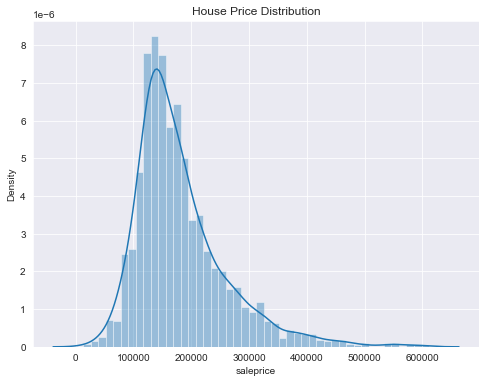

In [540]:
plt.figure(figsize=(8,6))
sns.distplot(y)
title = plt.title("House Price Distribution")

The distribution of SalePrice is right-skewed. Let's check its Skewness and Kurtosis statistics.

In [541]:
print(f"""Skewness: {y.skew()}
Kurtosis: {y.kurt()}""")

Skewness: 1.5575514385863427
Kurtosis: 3.579003386146362


2.2. Numerical Features

Top 10 numerical variables highly correlated with SalePrice:

In [542]:
corr_mat = train_data.corr().saleprice.sort_values(ascending=False)
corr_mat.head(11)

saleprice         1.000000
overall_qual      0.800207
gr_liv_area       0.697038
garage_area       0.650270
garage_cars       0.648220
total_bsmt_sf     0.628925
1st_flr_sf        0.618486
year_built        0.571849
year_remod/add    0.550370
full_bath         0.537969
garage_yr_blt     0.533922
Name: saleprice, dtype: float64

What are the top 10 features selected by Recursive Feature Elimination?

In [543]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=10, step=1)
selector = rfe.fit(X_train.fillna(0).select_dtypes(exclude='object'), y)
selectedFeatures = list(
    X.select_dtypes(exclude='object').columns[selector.support_])
selectedFeatures

['overall_qual',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'totrms_abvgrd',
 'fireplaces',
 'garage_cars']

According to above analyses, Overall Quality, Living Area, Number of Full Baths, Size of Garage and Year Built are some of the most important features in determining house price. Let's take a closer look at them.

# Overall Quality 

Overall quality is the most important feature in both analyses. It is clear that higher quality makes the house more expensive.

plt.figure(figsize=(8, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data, palette='GnBu')
title = plt.title('House Price by Overall Quality')

Living Area

Living area has a linear relationship with house price. In the scatter plot below, we can clearly see some outliers in the data, especially the two houses in the lower-right corner with living area greater than 4000 sqft and price lower than $200,000.

Correlation:  0.6970384443056613


<Figure size 432x432 with 0 Axes>

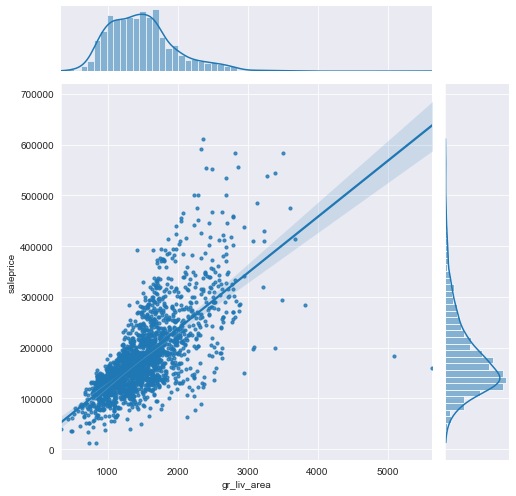

In [544]:
def plotCorrelation(variables):
    """
    1. Print correlation of two variables
    2. Create jointplot of two variables
    """
    # Print correlation
    print("Correlation: ", train_data[[variables[0],
                                       variables[1]]].corr().iloc[1, 0])

    # Create jointplot
    plt.figure(figsize=(6, 6))
    sns.jointplot(train_data[(variables[0])],
                  train_data[(variables[1])],
                  kind='reg',
                  height=7,
                  scatter_kws={'s': 10},
                  marginal_kws={'kde': True})


plotCorrelation(['gr_liv_area', 'saleprice'])

GarageCars

Interestingly, houses with garage which can hold 4 cars are cheaper than houses with 3-car garage.

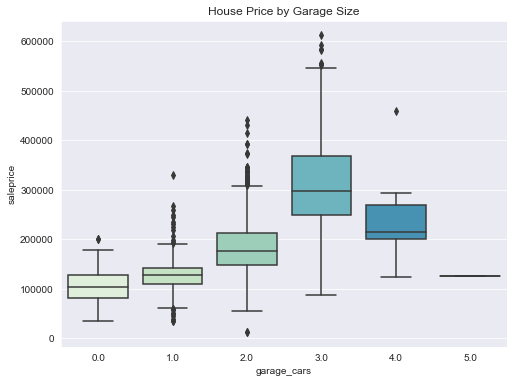

In [545]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='garage_cars', y='saleprice', data=train_data, palette='GnBu')
title = plt.title('House Price by Garage Size')

Year Built

The age of the house also plays an important role in its price. Newer houses have higher average prices. There are several houses built before 1900 having a high price.

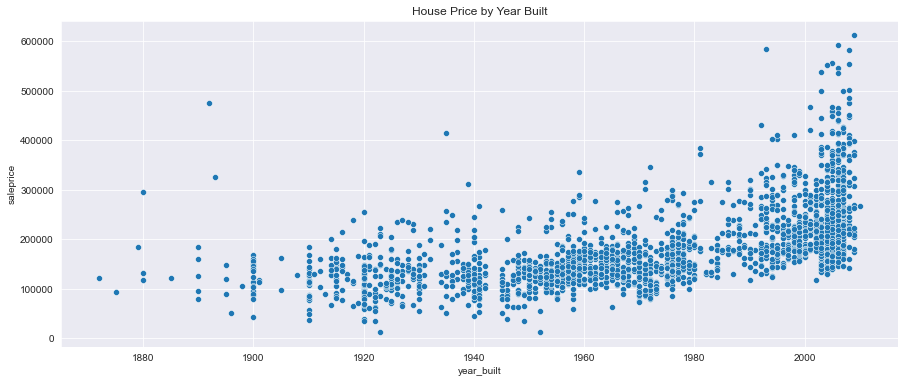

In [546]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='year_built', y='saleprice', data=train_data)
title = plt.title('House Price by Year Built')

# 2.3. Categorical Variables

Using ANOVA, I have identified 15 categorical features having p-values lower than 0.01:

In [547]:

sigCatCols = [
    'street', 'land_contour', 'lot_config', 'land_slope', 'neighborhood',
    'condition_1', 'condition_2', 'roof_matl', 'exter _qual', 'bsmt_qual',
    'bsmt_exposure', 'kitchen_qual', 'functional', 'garage_qual', 'pool_qc'
]

Let's explore some of them.

In [548]:
def visualizeCatFeature(feature):
    """
    Visualize the relationship between `SalePrice` and categorical feature using box plots
    """
    # Descending order of levels sorted by median SalePrice
    featOrder = train_data.groupby(
        [feature]).median().saleprice.sort_values(ascending=False).index

    # Create box plot
    sns.boxplot(x=feature,
                y='saleprice',
                data=train_data,
                order=featOrder,
                palette='GnBu_r')

Neighborhood

There is a big difference in house prices among neighborhood in Ames. The top 3 expensive neighborhoods are NridgHt, NoRidge and StoneBr with median house prices of approximately $300,000, three times as high as the median of the 3 cheapest neighborhoods, which are BrDale, DOTRR and MeadowV.

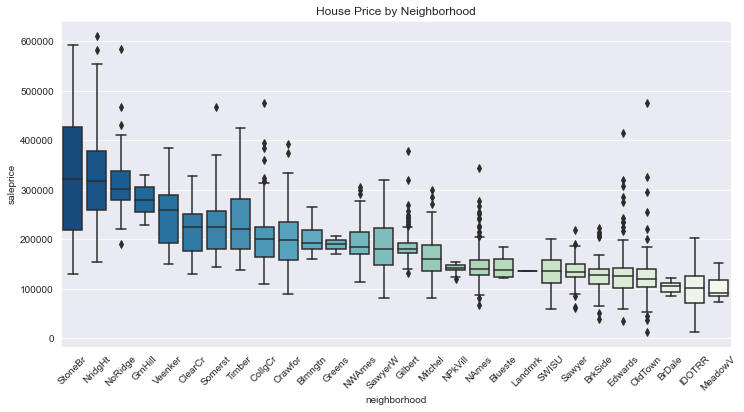

In [549]:
plt.figure(figsize=(12, 6))
visualizeCatFeature('neighborhood')
title = plt.title('House Price by Neighborhood')
tick = plt.xticks(rotation=45)

Roof Material

Houses using Wood Shingles roof are the most expensive with price ranging from $300,000 to \$450,000. There are also a lot of expensive houses using Standard Composite Shingle roof.

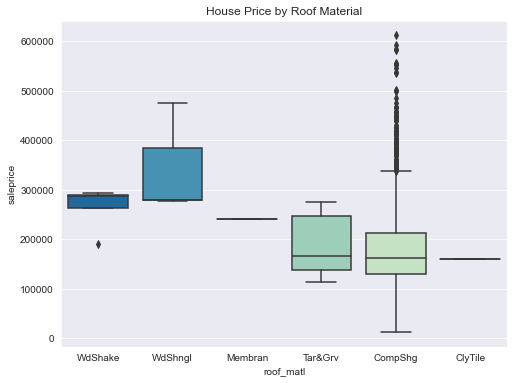

In [550]:
plt.figure(figsize=(8, 6))
visualizeCatFeature('roof_matl')
title = plt.title('House Price by Roof Material')

Kitchen Quality

Kitchen Quality is another important feature to predict house price. There is a very big difference in price between houses with different kitchen quality. For example, the average price difference between a house with a good kitchen and one with an excellent kitchen is about $120,000.

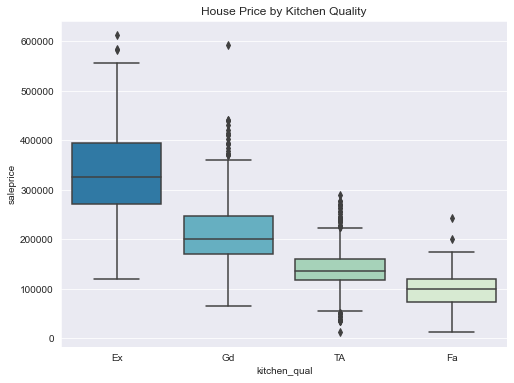

In [551]:
plt.figure(figsize=(8, 6))
visualizeCatFeature('kitchen_qual')
title = plt.title('House Price by Kitchen Quality')

# 2.4. Correlations

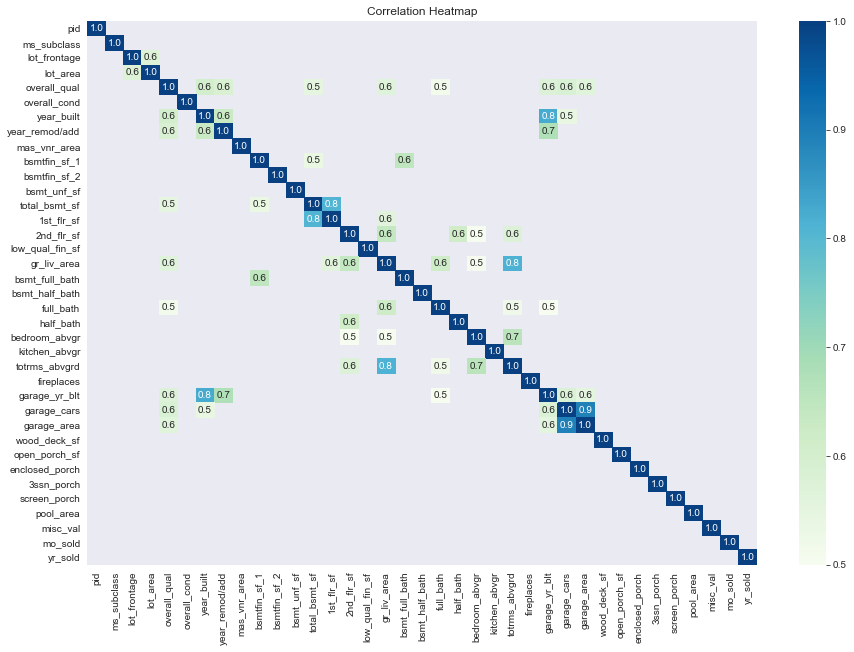

In [552]:
# Create correlation matrix from train data excluding `SalePrice`
corr_mat = train_data.iloc[:, :-1].corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

There is multicollinearity in our training data. Below features are highly correlated:
- GarageCars and GarageArea
- GarageYrBlt and YearBuilt
- 1stFlrSF and TotalBsmtSF
- GrLivArea and TotRmsAbvGrd

Multicolliniearity has a negative impact on our prediction models and makes standard errors of our estimates increase. Therefore, for each pair of highly correlated features, I will remove a feature that has a lower correlation with SalePrice.

# 2.5. Missing Values

Most machine learning algorithms give an error when we train them on data with missing values. Therefore, it's important to identify them before deciding how to handle them (drop features or impute missing value).

In [553]:
missing_data_count = X.isnull().sum()
missing_data_percent = X.isnull().sum() / len(X) * 100

missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

print(f"There are {missing_data.shape[0]} features having missing data.\n")
print("Top 10 missing value features:")
missing_data.head(10)

There are 27 features having missing data.

Top 10 missing value features:


,Count,Percent
pool_qc,2916,99.556163
misc_feature,2823,96.381017
alley,2731,93.240014
fence,2357,80.471151
fireplace_qu,1422,48.548993
lot_frontage,490,16.729259
garage_cond,159,5.428474
garage_qual,159,5.428474
garage_finish,159,5.428474
garage_yr_blt,159,5.428474


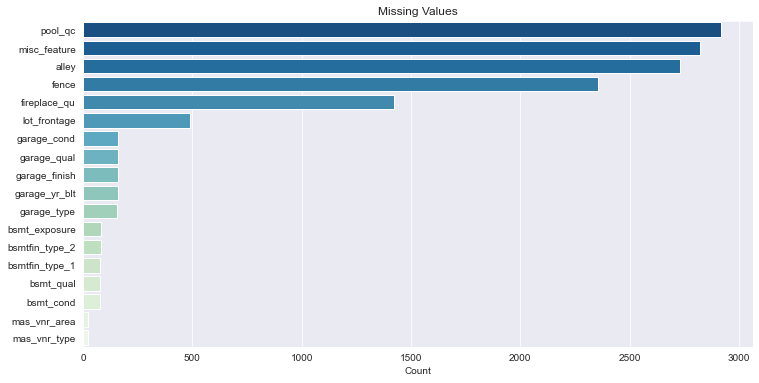

In [554]:
plt.figure(figsize=(12, 6))
sns.barplot(y=missing_data.head(18).index,
            x=missing_data.head(18).Count,
            palette='GnBu_r')
title = plt.title("Missing Values")

With some basic understandings of the data set and features, let's move to data preprocessing and modeling steps.

# 3. Data Preprocessing and Feature Engineering

In [555]:
# 3.1. Missing Values

In [556]:
missing_data_count = X.isnull().sum()
missing_data_percent = X.isnull().sum() / len(X) * 100
missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

In [557]:
missing_data.head(10)

,Count,Percent
pool_qc,2916,99.556163
misc_feature,2823,96.381017
alley,2731,93.240014
fence,2357,80.471151
fireplace_qu,1422,48.548993
lot_frontage,490,16.729259
garage_cond,159,5.428474
garage_qual,159,5.428474
garage_finish,159,5.428474
garage_yr_blt,159,5.428474


In [558]:
from sklearn.impute import SimpleImputer
# Group 1:
group_1 = [
    'pool_qc', 'misc_feature', 'alley', 'fence', 'fireplace_qu', 'garage_type',
    'garage_finish', 'garage_qual', 'garage_cond', 'bsmt_qual', 'bsmt_cond',
    'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'mas_vnr_type'
]
X[group_1] = X[group_1].fillna("None")

# Group 2:
group_2 = [
    'garage_area', 'garage_cars', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf',
    'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'mas_vnr_area'
]

X[group_2] = X[group_2].fillna(0)

# Group 3:
group_3a = [
    'functional', 'ms_zoning', 'electrical', 'kitchen_qual', 'exterior_1st',
    'exterior_2nd', 'sale_type', 'utilities'
]

imputer = SimpleImputer(strategy='most_frequent')
X[group_3a] = pd.DataFrame(imputer.fit_transform(X[group_3a]), index=X.index)

X['lot_frontage'] = X['lot_frontage'].fillna(X['lot_frontage'].mean())
X['garage_yr_blt'] = X['garage_yr_blt'].fillna(X['year_built'])

Let's check whether there is any missing value left:

In [559]:
sum(X.isnull().sum())

0

All missing values have been handled.

3.2. Outliers

Because regression models are very sensitive to outlier, we need to be aware of them. Let's examine outliers with a scatter plot.

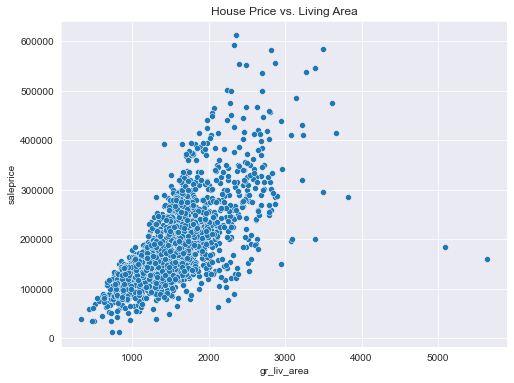

In [560]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='gr_liv_area', y='saleprice', data=train_data)
title = plt.title('House Price vs. Living Area')

There are two observations lying separately from the rest. They have large living area but low price. They are the outliers that we are looking for. I will delete them from the training set.




In [561]:
outlier_index = train_data[(train_data['gr_liv_area'] > 4000)
                           & (train_data.saleprice < 200000)].index
X.drop(outlier_index, axis=0, inplace=True)
y.drop(outlier_index, axis=0, inplace=True)

In [562]:
ordinal_features = ['lot_shape', 'utilities', 'land_slope',  'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating_qc', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence']

cats = {"category_1" : ['IR1', 'IR2' ,'IR3', 'Reg'], "category_2" : [ 'NoSewr',  'NoSeWa', 'AllPub'],
            "category_3" : ['Gtl' ,'Mod' ,'Sev'],"category_4" : ['None', 'Po', 'Fa', 'TA', 'Gd' ,'Ex'],
            "category_5" : ['None','No', 'Av', 'Mn','Gd' ],"category_6" : ['None',  'Unf', 'LwQ' ,'Rec','BLQ','ALQ', 'GLQ'],
            "category_7" : ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],"category_8" : ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
            "category_9" : ['None', 'Unf', 'RFn', 'Fin'],"category_10" : ['N', 'P', 'Y'],"category_11" : ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], "category_12" : ['Po', 'Fa', 'TA', 'Gd' ,'Ex']}

In [563]:
#def ordinal_transformer(data_train, data_test):
data_copy= pd.DataFrame(X, columns = X[ordinal_features].columns, index = X[ordinal_features].index)
for feature in ordinal_features:
    for category_n, category in cats.items():
        try:
            oc = OrdinalEncoder(categories = [category])
            oc.fit(data_copy[[feature]])
            data_copy[feature] = oc.transform(X[[feature]])
            X[feature] = data_copy[feature]
        except:
            pass

In [564]:
def feature_changes(dataset):
    #overall state
    dataset['overall_state'] = dataset['overall_qual']*dataset['overall_cond']
    #overall size
    dataset['hse_sf'] = dataset['total_bsmt_sf'] + dataset['1st_flr_sf']+ dataset['2nd_flr_sf']
    #overall age
    updated_age = lambda x, y: max([[item for item in x],[item for item in y]])
    dataset['latest_remod'] = updated_age(dataset['year_built'], dataset['year_remod/add'])
    dataset['hse_age'] = dataset['yr_sold'] - dataset['year_built']


    #exterior state
    dataset['exterior_state'] = dataset['exter_qual']*dataset['exter_cond']

    #bsmt state
    dataset['bsmt_state'] = dataset['bsmt_qual']*dataset['bsmt_cond']
    #bsmt area
    dataset['bsmt_fin_area'] = (dataset['bsmtfin_type_1']*dataset['bsmtfin_sf_1']) + (dataset['bsmtfin_type_2']*dataset['bsmtfin_sf_2'])


    #baths
    dataset['total_baths'] = dataset['bsmt_full_bath'] + dataset['full_bath'] + 0.5*(dataset['bsmt_half_bath'] +dataset['half_bath'])

    #Kitchen
    dataset['kitchen'] = dataset['kitchen_abvgr'] * dataset['kitchen_qual']

    #fireplace
    dataset['fireplace'] = dataset['fireplaces'] * dataset['fireplace_qu']

    #Garage state
    dataset['garage_state'] = dataset['garage_qual']*dataset['garage_cond']*dataset['garage_finish']

    #garage age 
    dataset['garage_age'] = dataset['yr_sold'] - dataset['garage_yr_blt']
    
    #garage size
    dataset['garage_size_per_car'] = dataset['garage_area'] - dataset['garage_cars']
    #pool
    dataset['pool_state'] = dataset['pool_area'] * dataset['pool_qc']

In [565]:
feature_changes(X)

# 3.3.2. Label Encoding

Ordinal categorical features are label encoded.

In [566]:
#from sklearn.preprocessing import LabelEncoder

# Ordinal categorical columns
'''
#label_encoding_cols = [
    "alley", "bsmt_cond", "bsmt_exposure", "bsmtfin_type_1", "bsmtfin_type_2",
    "bsmt_qual", "exter_cond", "exter_qual", "fireplace_qu", "functional",
    "garage_cond", "garage_qual", "heating_qc", "kitchen_qual", "land_slope",
    "lot_shape", "paved_drive", "pool_qc", "street", "utilities"
]

# Apply Label Encoder
label_encoder = LabelEncoder()

for col in label_encoding_cols:
    X[col] = label_encoder.fit_transform(X[col])
'''

'\n#label_encoding_cols = [\n    "alley", "bsmt_cond", "bsmt_exposure", "bsmtfin_type_1", "bsmtfin_type_2",\n    "bsmt_qual", "exter_cond", "exter_qual", "fireplace_qu", "functional",\n    "garage_cond", "garage_qual", "heating_qc", "kitchen_qual", "land_slope",\n    "lot_shape", "paved_drive", "pool_qc", "street", "utilities"\n]\n\n# Apply Label Encoder\nlabel_encoder = LabelEncoder()\n\nfor col in label_encoding_cols:\n    X[col] = label_encoder.fit_transform(X[col])\n'

# 3.3.3. Transform Numerical Variables to Categorical Variables

Because I have calculated age of houses, YearBuilt is no longer needed. However, YrSold could have a large impact on house price (e.g. In economic crisis years, house price could be lower). Therefore, I will transform it into categorical variables.
Like YrSold, some numerical variables don't have any ordinal meaning (e.g. MoSold, MSSubClass). I will transform them into categorical variables.

In [567]:
to_factor_cols = ['yr_sold', 'mo_sold', 'ms_subclass']

for col in to_factor_cols:
    X[col] = X[col].apply(str)

# 3.4. Skewness and Normalizing Variables

Normal distribution is one of the assumption that linear regression relies on. Therefore, transfoming skewed data will help our models perform better.
First, let's examine the target variable SalePrice with Distribution plot and Quantile-Quantile plot.

# Target variable

In [568]:
from scipy import stats
from scipy.stats import norm

In [569]:
def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()

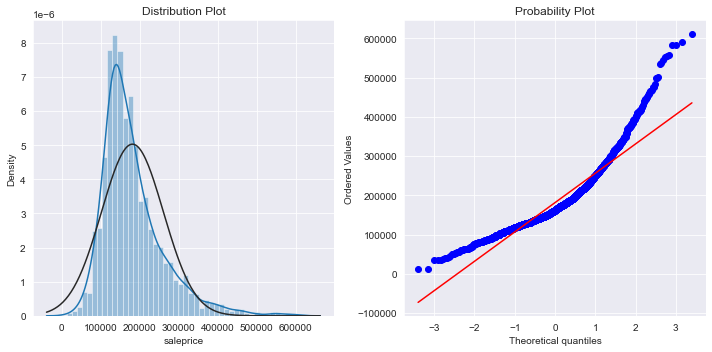

In [570]:
normality_plot(y)

One of the methods to normalize right-skewed data is using log transformation because big values will be pulled to the center. However, log(0) is Nan, so I will use log(1+X) to fix skewness instead.

In [571]:
y = np.log(1 + y)

And this is SalePrice after log transformation. The sknewness has been fixed.

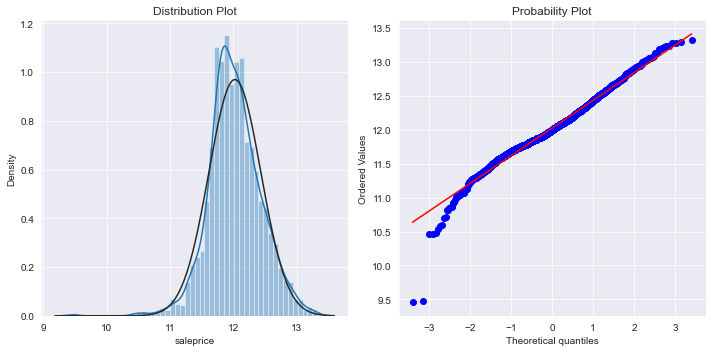

In [572]:
normality_plot(y)

In the next step I will examine skewness in the rest of numerical variables and use log transformation to fix them,

Fixing skewness in other numerical variables

If skewness is less than -1 or greater than 1, the distribution is highly skewed.

If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.

If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
Below are skewed features in our original train data.

In [573]:
skewness = train_data.skew().sort_values(ascending=False)
skewness[abs(skewness) > 0.75]

misc_val           20.657398
pool_area          16.700228
3ssn_porch         11.827201
low_qual_fin_sf    11.501289
lot_area            9.204950
kitchen_abvgr       4.348274
bsmtfin_sf_2        4.239955
bsmt_half_bath      3.946994
screen_porch        3.859110
enclosed_porch      2.864913
mas_vnr_area        2.594917
open_porch_sf       2.298022
wood_deck_sf        2.017081
lot_frontage        1.811116
1st_flr_sf          1.635146
bsmtfin_sf_1        1.603090
saleprice           1.557551
total_bsmt_sf       1.388913
ms_subclass         1.381004
gr_liv_area         1.281492
bsmt_unf_sf         0.908480
2nd_flr_sf          0.874577
totrms_abvgrd       0.843940
dtype: float64

Let's check normality of GrLivArea:

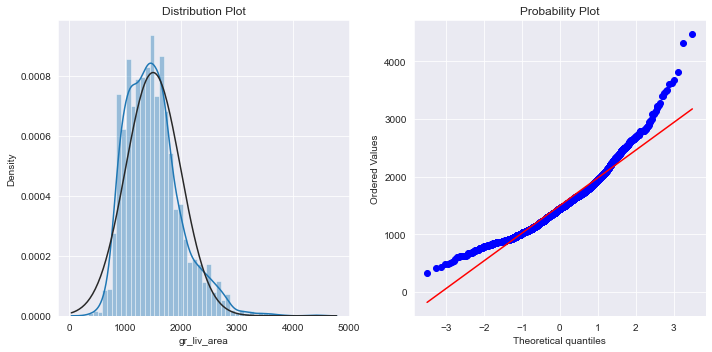

In [574]:
normality_plot(X['gr_liv_area'])

In [575]:
# List of skewed columns
skewed_cols = list(skewness[abs(skewness) > 0.5].index)

# Remove 'MSSubClass' and 'SalePrice'
skewed_cols = [
    col for col in skewed_cols if col not in ['ms_subclass', 'saleprice']
]

# Log-transform skewed columns
for col in skewed_cols:
    X[col] = np.log(1 + X[col])


Below is normality of GrLivArea after log-transformation. Skewness has been fixed.

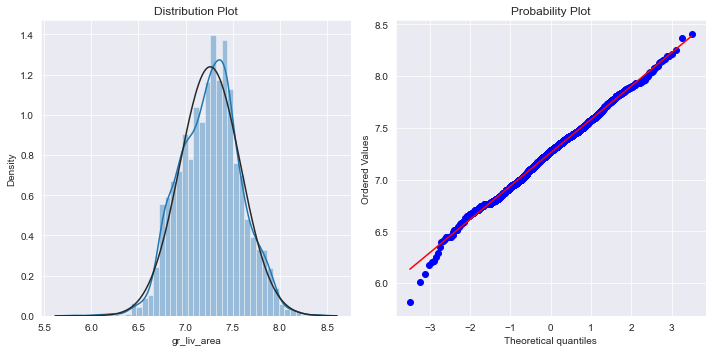

In [576]:
normality_plot(X['gr_liv_area'])

# 3.5. Feature Scaling

Except for Decision Tree and Random Forest, it is highly recommended to standardize the data set before running machine learning algorithms since optimization methods and gradient descent run and converge faster on similarly scaled features.


However, outliers can often influence the sample mean and standard deviation in a negative way, and models like Lasso and Elastic Net are very sensitive to outliers. In such cases, the median and the interquartile range often give better results. I will use RobustScaler to transform the training data.

In [577]:
from sklearn.preprocessing import RobustScaler
numerical_cols = list(X.select_dtypes(exclude=['object']).columns)
scaler = RobustScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 3.6. One-hot Encoding

In [578]:
X = pd.get_dummies(X, drop_first=True)
print("X.shape:", X.shape)

X.shape: (2927, 244)


After preprocessing the train and test data, I split them again to perform modeling.

In [579]:
ntest = len(test_data)
X_train = X.iloc[:-ntest, :]
X_test = X.iloc[-ntest:, :]
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (2049, 244)
X_test.shape: (878, 244)


# 4. Modeling

In model evaluation, it's a common practice to split the entire training data into 2 sets of data (train and test). However, a model may work very well on a set of test data but have a poor performance on other sets of unseen data.
A solution to this problem is a procedure called cross-validation (CV). In the example below, under the basic approach, called k-fold CV, the training set is split into 5 smaller sets. Then, for each fold, a model is trained using the other 4 folds and evaluated on the remaining fold. The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop.

I will write a function to get the Root Mean Squared Logarithmic Error (RMSLE) for my models using cross-validation. There is one note here: because I have transformed the target variable to log(1+y) , the Mean Squared Error for log(1+y) is the Mean Squared Logarithmic Error for SalePrice.

In [580]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def getRMSLE(model):
    """
    Return the average RMSLE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSLE score
    rmse = np.sqrt(-cross_val_score(
        model, X_train, y, scoring="neg_mean_squared_error", cv=kf))

    return rmse.mean()

def R2_score_train(model):
    R2 = cross_val_score(model, X_train, y, cv = 10).mean()
    return (R2)
          
def R2_score_test(model):
    R2 = cross_val_score(model, X_test, y_test, cv = 10).mean()
    return (R2)

def display_R2_scores(model, X_train, y_train, X_test, y_test):
    print(f'The mean cross validation score for this model is {round(cross_val_score(model, X_train, y_train).mean(),4)}.')
    print(f'The training score for this model is {round(model.score(X_train, y_train), 4)}.')
    print(f'The testing score for this model is {round(model.score(X_test, y_test),4)}.')

# 4.1. Linear Regressions

In [581]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [582]:
y1=pd.merge(X,y,on='Id').saleprice
X1=pd.merge(X,y,on='Id').iloc[:,:-1]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size = 0.2, random_state = 1234567)
lr_prelim = LinearRegression()
lr_prelim.fit(X_train_1, y_train_1);
display_R2_scores(lr_prelim, X_train_1, y_train_1, X_test_1, y_test_1)

The mean cross validation score for this model is 0.9003.
The training score for this model is 0.9459.
The testing score for this model is 0.8477.


# 4.2. Regularized Regressions

In [583]:
from sklearn.linear_model import Ridge, Lasso

4.2.1. Ridge Regression

In the regularized linear regression (Ridge), we try to minimize:
𝐽(𝜃)=12𝑚(∑𝑖=1𝑚(ℎ𝜃(𝑥(𝑖))−𝑦(𝑖))2)+𝜆2𝑚(∑𝑗=1𝑛𝜃2𝑗)
J
(
θ
)
=
1
2
m
(
∑
i
=
1
m
(
h
θ
(
x
(
i
)
)
−
y
(
i
)
)
2
)
+
λ
2
m
(
∑
j
=
1
n
θ
j
2
)
 
where  𝜆
λ
  is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters  𝜃𝑗
θ
j
  increase, the penalty increases as well.
I will find the  𝜆
λ
  that gives me the smallest RMSLE from cross-validation:

Best lambda: 16.4
RMSLE: 0.11565925214148706


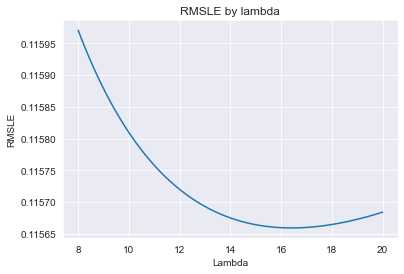

In [584]:
lambda_list = list(np.linspace(8, 20, 101))

rmsle_ridge = [getRMSLE(Ridge(alpha=lambda_)) for lambda_ in lambda_list]
rmsle_ridge = pd.Series(rmsle_ridge, index=lambda_list)

rmsle_ridge.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_ridge.idxmin())
print("RMSLE:", rmsle_ridge.min())

In [585]:
ridge = Ridge(alpha=rmsle_ridge.idxmin())
ridge.fit(X_train, y)

Ridge(alpha=16.4)

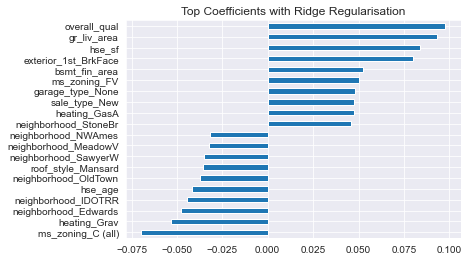

In [586]:
ridge_coefs = pd.Series(ridge.coef_, index = X_train.columns)
imp_coefs = pd.concat([ridge_coefs.sort_values().head(10), ridge_coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Top Coefficients with Ridge Regularisation')
plt.show()

In [587]:
print('R2 score on train is {}'.format(R2_score_train(ridge)))

R2 score on train is 0.921370746546262


4.2.2. Lasso Regression

Lasso Regression is very similar to Ridge regression. One difference is that in the regularization term, instead of using sum of squared of  𝜃
θ
 , we use sum of absolute value of  𝜃
θ
 :
𝐽(𝜃)=12𝑚(∑𝑖=1𝑚(ℎ𝜃(𝑥(𝑖))−𝑦(𝑖))2)+𝜆2𝑚(∑𝑗=1𝑛|𝜃𝑗|)
J
(
θ
)
=
1
2
m
(
∑
i
=
1
m
(
h
θ
(
x
(
i
)
)
−
y
(
i
)
)
2
)
+
λ
2
m
(
∑
j
=
1
n
|
θ
j
|
)
 
Another big difference is that Ridge Regresion can only shrink parameters close to zero while Lasso Regression can shrink some parameters all the way to 0. Therefore, we can use Lasso Regression to perform feature selection and regression.
With the same method above, the best lambda_ for my Lasso model is 0.00065.

Best lambda: 0.000316
RMSLE: 0.11656724507136988


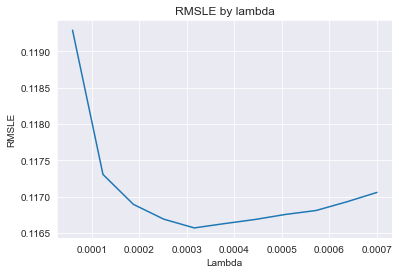

In [588]:
lambda_list = list(np.linspace(0.00006, 0.0007, 11))
rmsle_lasso = [
    getRMSLE(Lasso(alpha=lambda_, max_iter=100000)) for lambda_ in lambda_list
]
rmsle_lasso = pd.Series(rmsle_lasso, index=lambda_list)

rmsle_lasso.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_lasso.idxmin())     
print("RMSLE:", rmsle_lasso.min())

In [589]:
lasso = Lasso(alpha=rmsle_lasso.idxmin(), max_iter=100000)

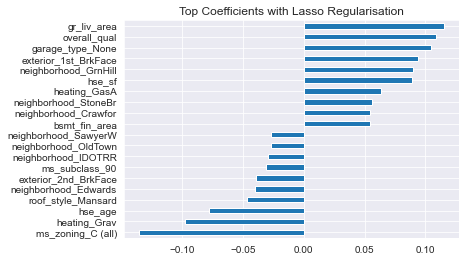

In [590]:
lasso.fit(X_train, y)
lasso_coefs = pd.Series(lasso.coef_, index = X_train.columns)
imp_coefs = pd.concat([lasso_coefs.sort_values().head(10), lasso_coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Top Coefficients with Lasso Regularisation')
plt.show()

In [591]:
print('R2 score on train is {}'.format(R2_score_train(lasso)))

R2 score on train is 0.9208252704719934


# 4.3. Elastic Net

Regularized regression and gradient boosting work very differently and they may perform well on different data points. Thus it is a good practice to get average predictions from these models. Below I create a new class for my averaging model.

In [592]:
from sklearn.linear_model import ElasticNet 

In [ ]:
l1_ratios = np.linspace(0.01, 1, 100)
alphas  = list(np.linspace(0, 1, 11))
rmsle_enet = []
for ratio in l1_ratios:
    rmsle_enet.append(getRMSLE(ElasticNet(l1_ratio = ratio)))

rmsle_enet = pd.Series(rmsle_enet, index=l1_ratios)

In [ ]:
rmsle_enet.plot(title="RMSLE by l1 ratio")
plt.xlabel("L1 ratio")
plt.ylabel("RMSLE")

In [ ]:
enet = ElasticNet(alpha=rmsle_enet.idxmin(), l1_ratio = rmsle_enet.idxmin(), max_iter=100000)

In [ ]:
enet.fit(X_train, y)
enet_coefs = pd.Series(enet.coef_, index = X_train.columns)
imp_coefs = pd.concat([enet_coefs.sort_values().head(10), enet_coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Top Coefficients with ElasticNet Regularisation')
plt.show()

The RMSLE score of the Enet model is slightly better than both the ridge or Lasso models and will be used to make predictions for the kaggle submission. In the last step, I will train my final model on the whole training data, make predictions from the test data and save my output.

In [ ]:
print('R2 score on train is {}'.format(R2_score_train(enet)))

In [ ]:
predictions = enet.predict(X_test)
final_predictions = np.exp(predictions) - 1
output = pd.DataFrame({'Id': test_data.index, 'SalePrice': final_predictions})
output.to_csv('submission.csv', index=False)

# 5. Conclusion

In this project, I have conducted a detailed EDA to understand the data and important features. Based on exploratory analysis, I performed data preprocessing and feature engineering. Finally, I train regularized regression models (Ridge, Lasso), and take average predictions from these models to predict final price of each house. By the time I write this notebook, my best model has Mean Absolute Error of 12293.919, ranking 95/15502, approximately top 0.6% in the Kaggle leaderboard.

Among the 4 models, the ElasticNet model performed the best and was able to explain about 92% of variance in sales prices on the train data and produced the lowest RMSE of 0.116 on both the train and test data. Hence, our team recommends ElasticNet model to predict the sale price due to the normality of distribution.

However, since we used the 2006 to 2010 dataset to build the model and the real estate market is constantly changing, our best model might not fit the current market. Going forward, we would recommend frequently recording housing specs and sales prices in the Ames area and maintaining a database with the relevant information to continually improve on the model’s ability to predict sales price, even in the face of an ever-changing market landscape.

# 6. Reference
1. [Population of Ames Iowa](https://datausa.io/profile/geo/ames-ia/)
2. [City of Ames Website](https://www.cityofames.org/about-ames/about-ames)
3. [Machine Learning in Real Estate](https://unionstreetmedia.com/the-rise-of-machine-learning-in-real-estate/#:~:text=Personalized%20Marketing%20Automation%20%E2%80%93%20machine%20learning,neighborhood%20and%20property%20is%20best)
4. [Ames Housing Data - Original Article](http://jse.amstat.org/v19n3/decock.pdf)